Utilizzo di pynetlogo

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
#import networkx as nx

%matplotlib widget

In [2]:
## perché funzioni: installato tutto da conda tranne pynetlogo, installato per ultimo
## java-21-openjdk
import sys
if (sys.platform == 'linux') :
    netlogo = pynetlogo.NetLogoLink(
        gui=True,
        netlogo_home="/opt/netlogo/",
    )
else:
    netlogo = pynetlogo.NetLogoLink(
    gui=True,
)

In [3]:
netlogo.load_model("./EC.nlogo")

In [4]:
# SETUP VARIABILI GLOBALI
global_vars = {
  'N': 1000,
  'beta': 0.8,
  'mutrue': 0.,
  'vartrue': 1.,
  'update-type': 1,
  'var-c': 0.25,
  'var-d': 2
}

netlogo.command('clear-all')
for name in global_vars:
  netlogo.command(f'set {name} {global_vars[name]}')

netlogo.command('setup')

In [5]:
netlogo.report('vartrue')

1.0

In [6]:
def values(var: str):
  '''
  Restituisce un array con i valori di una variabile per tutti i nodi.
  '''
  return netlogo.report(f"map [s -> [{var}] of s] sort nodes")

In [7]:
values('var').max()

np.float64(4.803718526551127)

In [8]:
iters = 100
mus = []
sigma2s = []
mus.append(values('mu0'))
sigma2s.append(values('var0'))


In [9]:
for n in range(1,iters+1):
  netlogo.command('go')
  mus.append(values('mu'))
  sigma2s.append(values('var'))
  print(f"\r{n}/{iters}",end="",flush=True)
print()

100/100


In [10]:
netlogo.report("iter")

100.0

In [11]:
meanmu = np.array([np.mean(mu) for mu in mus])
meansigma = np.sqrt(np.array([np.mean(var) for var in sigma2s]) )

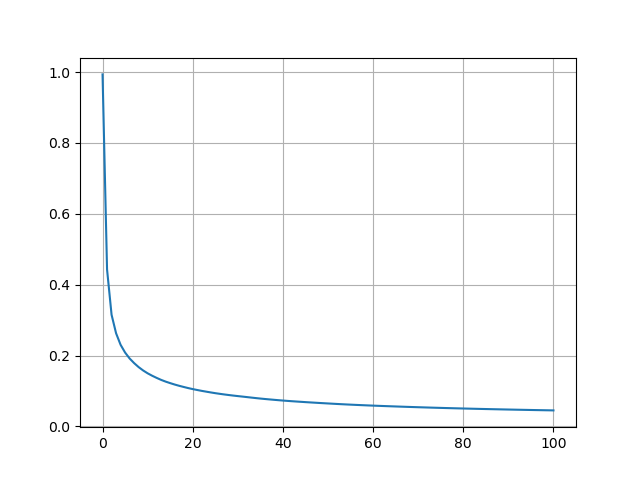

In [12]:
plt.close('all')
plt.plot(meansigma)
plt.grid()

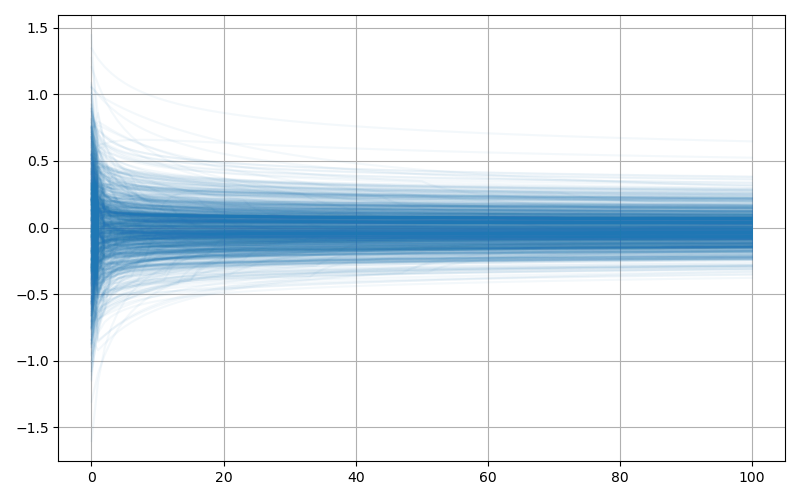

In [18]:
fig, ax = plt.subplots(figsize = (8,5), layout='tight')
for i in range(1000):
  ax.plot([mu[i] for mu in mus],alpha=0.05, color='C0')

#ax.plot( np.array(mus)[:,0] )

ax.grid()

(array([  1.,   1.,   0.,   1.,   0.,   3.,   2.,   5.,   4.,   6.,   8.,
         10.,  12.,  13.,   3.,  26.,  11.,   0.,  12.,  30.,  87.,   6.,
          7.,   4.,   5.,   6.,   4.,  11.,   7.,  43.,   6., 586.,  25.,
         14.,   4.,   4.,   1.,   7.,   2.,   2.,   0.,   1.,   2.,   2.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.]),
 array([0.0067439 , 0.00803119, 0.00931848, 0.01060577, 0.01189306,
        0.01318035, 0.01446764, 0.01575493, 0.01704222, 0.01832951,
        0.0196168 , 0.0209041 , 0.02219139, 0.02347868, 0.02476597,
        0.02605326, 0.02734055, 0.02862784, 0.02991513, 0.03120242,
        0.03248971, 0.033777  , 0.03506429, 0.

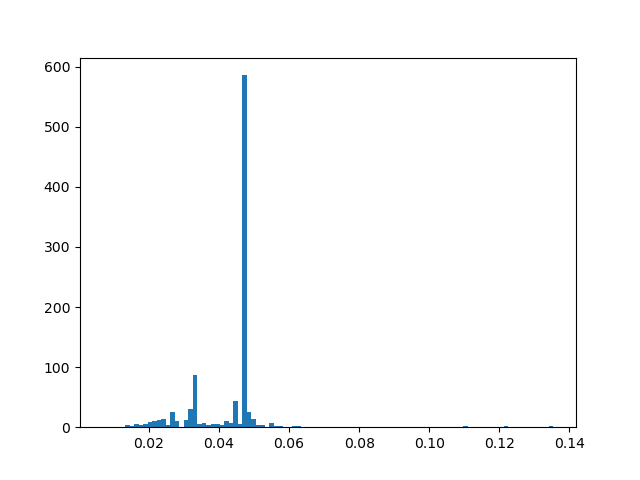

In [19]:
plt.close('all')
plt.hist(sigma2s[-1]**0.5,bins=100)

In [20]:
np.min(mus[-1])

np.float64(-0.37732368996637217)

In [21]:
netlogo.kill_workspace()